## SDF Library

In [1]:
import jax.numpy as jnp
from jax.scipy.optimize import minimize
import jax
import matplotlib.pyplot as plt

In [2]:
def _length(a):
    return jnp.linalg.norm(a, axis=1)

ORIGIN = jnp.array((0, 0))

SEED = jax.random.PRNGKey(0)


def circle(radius=1, center=(0, 0)):
    center = jnp.array(center)
    def f(p):
        return _length(p - center) - radius

    return f

def translate(sdf, offset):
    offset = jnp.array(offset)
    def f(p):
        return sdf(p - offset)

    return f


def rotate(sdf, angle):
    s = jnp.sin(angle)
    c = jnp.cos(angle)
    m = 1 - c
    matrix = jnp.array(
        [
            [c, -s],
            [s, c],
        ]
    ).T

    def f(p):
        return sdf(jnp.dot(p, matrix))

    return f

def rotate_around_center(sdf, angle, center):
    center = jnp.array(center)

    def f(p):
        v = translate(rotate(translate(sdf, -center), angle), center)(p)
        return v

    return f

def rectangle(size=1, center=(0, 0)):
    center = jnp.array(center)
    size = jnp.array(size)

    def f(p):
        q = jnp.abs(p - center) - size / 2
        return _length(jnp.maximum(q, 0)) + jnp.minimum(jnp.amax(q, axis=1), 0)

    return f

def bottom_half_plane(p):
    return p[:, 1]

def intersection(sdf1, sdf2):
    def f(p):
        return jnp.maximum(sdf1(p), sdf2(p))
    return f
    


In [3]:
def show_sdf(sdf, bounds=(-1, 1), n=500):
    x = jnp.linspace(bounds[0], bounds[1], n)
    X, Y = jnp.meshgrid(x, x)

    grid_points = jnp.column_stack((X.flatten(), Y.flatten()))
    plt.imshow(1-inside(sdf)(grid_points).reshape(n, n), cmap="gray", origin="lower", extent=[bounds[0], bounds[1],bounds[0], bounds[1]])

In [4]:
N = 1000
shape = (N, 2)
dtype = jnp.float32

def naive_area(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    computed_sdf = sdf(random_numbers) < 0
    return jnp.sum(computed_sdf) / n * (bounds[1] - bounds[0])**2

In [5]:
def inside(sdf):
   def f(p):
       distance = sdf(p)
       return 1-jax.nn.sigmoid(100* distance)

   return f

In [6]:
def area(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    computed_sdf = inside(sdf)(points)
    return jnp.sum(computed_sdf) / n * (bounds[1] - bounds[0])**2
    

In [7]:
def centroid(sdf, bounds=[-1, 1], n=1000):
    points = jax.random.uniform(SEED, (n, 2), jnp.float32, bounds[0], bounds[1])
    inside_points = inside(sdf)(points)
    return jnp.average(points, weights=inside_points, axis=0)

## The boat problem

In [8]:
RELATIVE_DENSITY = 0.5
SAMPLE_SIZE = 10000
INTEGRATION_BOUNDS = (-3, 3)

In [9]:
def update_position(original_shape, original_shape_center, p1, p2):
    return translate(rotate_around_center(original_shape, p1, original_shape_center), (0, p2))

def alignment_cost(shape):
    shape_center_of_gravity = centroid(shape, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)
    shape_area = area(shape, bounds=(-5, 5), n=SAMPLE_SIZE)

    shape_weight = shape_area * RELATIVE_DENSITY

    displacement = intersection(bottom_half_plane, shape)
    buoyancy_center = centroid(displacement, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)

    displacement_weight = area(displacement, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)

    gravity_cost = displacement_weight - shape_weight
    torque_cost = (buoyancy_center - shape_center_of_gravity)[0]

    return jnp.linalg.norm(jnp.array([gravity_cost, torque_cost]))

In [25]:
def center_of_gravity(shape):
    return centroid(shape, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)

def center_of_buoyancy(shape):
    displacement = intersection(bottom_half_plane, shape)
    return centroid(displacement, bounds=INTEGRATION_BOUNDS, n=SAMPLE_SIZE)


In [34]:
def find_equilibrium(shape):
    shape_cof = center_of_gravity(shape)
    def cost(x):
        cost = alignment_cost(update_position(shape, shape_cof, x[0], x[1]))
        return cost

    res = minimize(jax.jit(cost), jnp.array((0., 0.)), method="BFGS")

    print("iterations", res.nit)
    print("end position change", res.x)

    end_shape = update_position(shape, shape_cof, res.x[0], res.x[1])
    print("final cost", alignment_cost(end_shape))

    show_sdf(end_shape, bounds=(-3, 3))

    plt.scatter(*center_of_gravity(end_shape), c="red")
    plt.scatter(*center_of_buoyancy(end_shape), c="blue")

In [41]:
def grad_at_origin(shape):
    shape_cof = center_of_gravity(shape)

    def cost(x, y):
        return alignment_cost(update_position(shape, shape_cof, x, y))
    return jax.value_and_grad(cost, (0, 1))(jnp.array(0.0), jnp.array(0.0))


### Solving the equilibrium of a rectangle

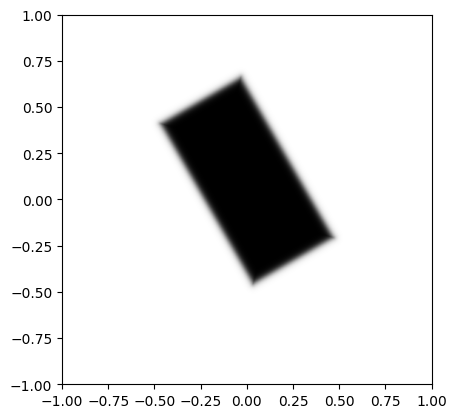

In [45]:
rectangle_sdf = translate(rotate(rectangle((1,0.5)), jnp.pi / 3), (0, 0.1))
show_sdf(rectangle_sdf)

In [44]:
grad_at_origin(rectangle_sdf)

(Array(0.13457096, dtype=float32),
 (Array(nan, dtype=float32, weak_type=True),
  Array(nan, dtype=float32, weak_type=True)))

We have a problem here - the grad at the origin is nan. I guess this comes from the amin function used in the (copied from sdfCAD) definition of the rectangle. We should probably look into improving this.

In order to figure out what is going on - let's try something easier - a circle.

### Solving the equilibrium of a circle

In [42]:
grad_at_origin(circle(1, (0, -0.5)))

(Array(0.89770174, dtype=float32),
 (Array(-0.03325758, dtype=float32, weak_type=True),
  Array(-2.035065, dtype=float32, weak_type=True)))

iterations 10
end position change [0.40803742 0.49084246]
final cost 0.008205301


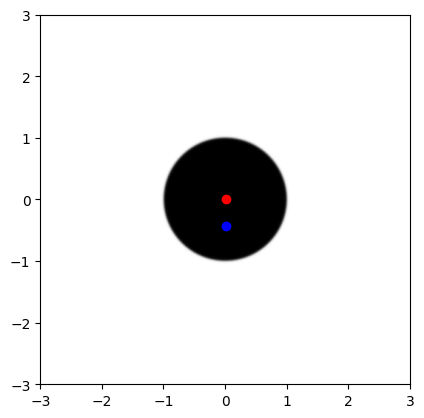

In [35]:
find_equilibrium(circle(1, (0, -0.5)))

In [ ]:
Yeah, it work - but this is only concerned with gravity. Let's try something a bit less symmetric

### Solving the equilibrium of a partial circle

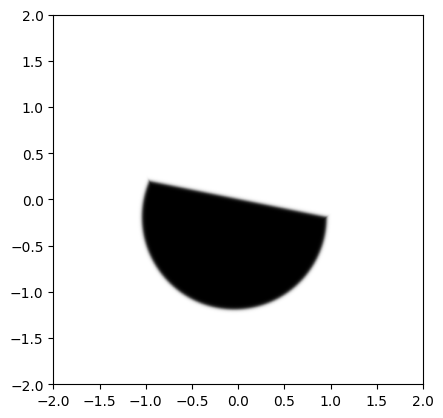

In [20]:
partial_circle = rotate(intersection(translate(circle(), (0, -0.2)), bottom_half_plane), 0.2)

show_sdf(partial_circle, bounds=[-2, 2])

In [43]:
grad_at_origin(partial_circle)

(Array(0.8543954, dtype=float32),
 (Array(-0.51542485, dtype=float32, weak_type=True),
  Array(-0.26591748, dtype=float32, weak_type=True)))

iterations 2
end position change [1.0308497  0.53183496]
final cost 0.102793306


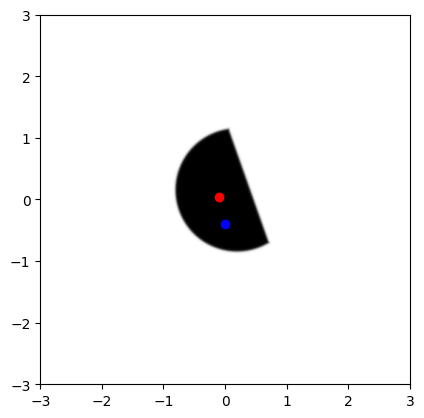

In [36]:
find_equilibrium(partial_circle)

It does not seem to converge to a place with cost 0... There is either a bug, a bad cost function or something wrong with our approach